In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

True

In [494]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
device = pcl.get_platforms()[0].get_devices()[2]
cntx = pcl.Context([device])
queue = pcl.CommandQueue(cntx)

with open(clfile, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()

In [495]:
device.name

'AMD Radeon R9 M370X Compute Engine'

In [496]:
theta = np.array([0.5, 0.5], dtype=np.float32)

In [497]:
theta.dtype

dtype('float32')

In [498]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

In [499]:
nsamps=1

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


In [500]:
X_all = pd.concat((X_1, X_0), ignore_index=True)

In [501]:
X_all = X_all.reindex(np.random.permutation(X_all.index))

In [502]:
X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [503]:
X.values

array([[  8.12192249,  -7.17198944],
       [ 12.19423199,   9.9346981 ]], dtype=float32)

In [504]:
cost_arr = np.zeros(shape=(X.shape[0],)).astype(np.float32)
temp_avg = np.zeros(shape=(4,)).astype(np.float32)

In [505]:
# compute cost
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)

theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)

cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
temp_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=temp_avg.nbytes)
scratch_buf = pcl.LocalMemory(np.float32().nbytes * 256)

nrows = np.int32(X.shape[0])
ncols = np.int32(X.shape[1])

out = np.zeros(shape=(X.shape[0],), dtype=np.float32)
out_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=out.nbytes)

In [506]:
sig_event = programs.sig(queue,
                         X.shape,
                         None,
                         X_buf,
                         theta_buf,
                         out_buf,
                         nrows,
                         ncols)

# cost_event = programs.logistic_cost_ols(queue,
#                                         X.shape,
#                                         None,
#                                         X_buf,
#                                         theta_buf,
#                                         y_buf,
#                                         cost_buf,
#                                         nrows,
#                                         ncols)

# reduction_event = programs.matrix_row_mean(queue,
#                                            (1024,),
#                                            (256,),
#                                            cost_buf,
#                                            temp_buf,
#                                            scratch_buf,
#                                            nrows,
#                                            np.int32(1))

In [507]:
nrows, ncols, theta.shape

(2, 2, (2,))

In [508]:



sig_event.wait()
pcl.enqueue_copy(queue, out, out_buf).wait()

# cost_event.wait()
# pcl.enqueue_copy(queue, cost_arr, cost_buf).wait()

# reduction_event.wait()
# pcl.enqueue_copy(queue, temp_avg, temp_buf).wait()


In [509]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def cost(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    cost = cost.sum()
    return cost

In [510]:
my_out = sig(X.values, theta)

In [511]:
my_out.shape, out.shape

((2,), (2,))

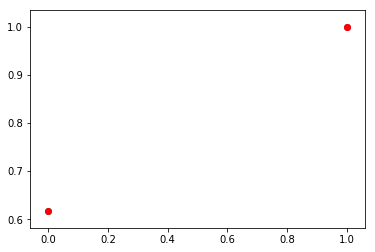

In [512]:
x = list(range(len(my_out)))
plt.scatter(x, my_out)
plt.scatter(x, out, color='r')
plt.show()


In [513]:
X.values.dot(theta)

array([  0.47496653,  11.06446457], dtype=float32)

In [514]:
out == my_out

array([ True,  True], dtype=bool)

In [515]:
X.values

array([[  8.12192249,  -7.17198944],
       [ 12.19423199,   9.9346981 ]], dtype=float32)

In [516]:
X.values.sum(axis=1)

array([  0.94993305,  22.12892914], dtype=float32)

In [469]:
out

array([  4.63284636,  15.84094238], dtype=float32)

In [418]:
my_out

array([ 0.99967003,  0.14995772], dtype=float32)

In [419]:
out -= 1.0

In [213]:
np.e == out

array([ True,  True,  True,  True], dtype=bool)